In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from transformers import BertTokenizer
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, TweetTokenizer
import time
import matplotlib.pyplot as plt
import random
from torch_scatter import scatter_max, scatter_mean, scatter_sum, scatter_std
from sklearn.model_selection import train_test_split, KFold
import torchmetrics
import lightning as L
from torch_geometric.data import Batch, Data
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from copy import copy
import spacy
from umap import UMAP

import string
import os
import PyPDF2
from bs4 import BeautifulSoup
import json
import gzip
import re
import collections
import csv
import math

In [2]:
nlp = spacy.load('en_core_web_lg', disable=['tok2vec','tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner'])
t_tokenizer = TweetTokenizer()
nlp.max_length = len(' '.join(list(nlp.vocab.strings)))+1
all_vocab_doc = nlp(' '.join(list(nlp.vocab.strings)))
all_vocab_str = [f'{t}' for t in all_vocab_doc]

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 50
folder_path = r'data\TextClassification\review_polarity'
t_tokenizer = TweetTokenizer()
device

device(type='cuda')

In [4]:
def load_dataset(dataset_path):
    pos_path = os.path.join(dataset_path, 'pos')
    neg_path = os.path.join(dataset_path, 'neg')
    pos_names = os.listdir(pos_path)
    neg_names = os.listdir(neg_path)
    df = []
    for pname in pos_names:
        file_path = os.path.join(pos_path, pname)
        with open(file_path, 'rt', encoding='utf8') as f:
            df.append([1, f.read()])
    
    for nname in neg_names:
        file_path = os.path.join(neg_path, nname)
        with open(file_path, 'rt', encoding='utf8') as f:
            df.append([0, f.read()])
    df = pd.DataFrame(data=df, columns=['label', 'text'])
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [5]:
keep_ratio = 1.0
df = load_dataset(r'Data\TextClassification\review_polarity')
# df.text = df.text.apply(lambda d: d[:50])
df.dropna(inplace=True)
df = df.iloc[:int(keep_ratio*df.shape[0])]
target_classes = ["Negative", "Positive"]
df.shape

(2000, 2)

In [6]:
class_list = df.label.unique()
class_id = {target_classes[i]:i for i in class_list}
id_class = {i:target_classes[i] for i in class_list}

In [7]:
char_set = set()
for doc in df.text.values:
    char_set.update(set(' '.join(t_tokenizer.tokenize(doc))))
len(char_set)

74

In [8]:
allowed_chars = string.ascii_letters + string.digits + string.punctuation + ' '
all_chars = set(''.join(char_set).join(allowed_chars))
vocab_dict = {c:i for i, c in enumerate(all_chars)}
if '\x01' not in vocab_dict:
    vocab_dict['\x01'] = len(vocab_dict)
char_Set = set(vocab_dict.keys())
num_embedding = len(vocab_dict)
vocab_dict_rev = dict(zip(list(vocab_dict.values()), list(vocab_dict.keys())))

In [9]:
class KFoldCharacterandTokenLevelDataset(Dataset):
    
    def __init__(self, X, y, num_classes, char_dict, tokenizer, shuffle=True, batch_size=128, k_folds=10, fold_idx=0) -> None:
        super().__init__()
        self.fold_idx = fold_idx
        kf = KFold(k_folds, shuffle=True, random_state=911)
        self.k_folds = list(kf.split(np.arange(len(y))))
        self.k_folds = [(np.array(f[0], dtype=np.longlong), np.array(f[1], dtype=np.longlong)) for f in self.k_folds]
        
        if batch_size > len(y)//k_folds:
            batch_size = len(y)//k_folds
        self.batch_size = batch_size
        
        if len(y) % batch_size*k_folds != 0:
            
            self.shortage = ((len(y) // (batch_size*k_folds))+1)*(batch_size*k_folds) - len(y)
            print(f"!!!! This amount of data added: {self.shortage}, change batch size or k-fold to reduce it!")
            empty_labels = [i%2 for i in range(self.shortage)]
            empty_strings = [id_class[l] for l in empty_labels]
            y = np.concatenate([y, empty_labels])
            X = np.concatenate([X, empty_strings])
        
        y = torch.from_numpy(y)
        self.shuffle = shuffle
        self.y = torch.nn.functional.one_hot(y, num_classes=num_classes).float()
        self.X = X
        self.char_dict = char_dict
        self.char_Set = set(char_dict.keys())
        self.vocab_size = len(self.char_dict)
        self.tokenizer = tokenizer
        # self.token_dict = token_dict
        # self.sentiment_dict = sentiment_dict
        self.max_token_count = 0
        
        self.all_data = []
        self.token_lengths = []
        self.token_embeddign_ids = []
        
        self.sum_a = 0
        
        for doc in tqdm(self.X):
            # tokens = self.tokenizer(''.join(c for c in doc if c in self.char_Set))
            # tokens = [t.text for t in tokens]
            tokens = self.tokenizer(doc)
            if len(tokens) == 0:
                tokens = ['empty']
                            
            token_lengths = [len(t) for t in tokens]
            tokens.append('\x01')
            
            token_lengths.append(len(tokens[-1])-1)
            token_lengths = torch.from_numpy(np.array(token_lengths, dtype=np.longlong))+1
            # token_embs = [self.token_dict[t] if t in self.token_dict else torch.zeros((64, ), dtype=torch.float32) for t in tokens]
            # token_sentiments = [self.sentiment_dict[t] if t in self.sentiment_dict else (0.0, 0.0) for t in tokens]
            # token_embs = torch.from_numpy(np.array(token_embs, dtype=np.float32))
            # token_sentiments = torch.from_numpy(np.array(token_sentiments, dtype=np.float32))
            doc = ' '.join(tokens)
            characters = torch.from_numpy(np.array([self.char_dict[t] for t in doc], dtype=np.longlong))
            token_positions = torch.arange(len(token_lengths), dtype=torch.long)
            token_indices = torch.repeat_interleave(token_positions, token_lengths)
            num_tokens = len(token_lengths)
            if num_tokens > self.max_token_count:
                self.max_token_count = num_tokens
            g_data = Data(x=characters,
                            token_positions=token_positions,
                            character_length = len(characters),
                            num_tokens = num_tokens,
                            token_indices=token_indices,
                            token_lengths=token_lengths,
                            # token_embeddings=token_embs,
                            # token_sentiments=token_sentiments
                            )
            self.all_data.append(g_data)
            
        self.all_data = Batch.from_data_list(self.all_data)
        self.update_split(self.fold_idx)
        
    def update_split(self, fold_idx):
        self.active_fold = self.k_folds[fold_idx]
        
        self.train_y = self.y[self.active_fold[0]]
        self.test_y = self.y[self.active_fold[1]]
        
        self.all_train_data = self.all_data[self.active_fold[0]]
        self.all_test_data = self.all_data[self.active_fold[1]]
        self.train()
        
    def train(self):
        self.update_sections(self.train_y, self.all_train_data)
        self.is_train=True
        
    def eval(self):
        self.update_sections(self.test_y, self.all_test_data)
        self.is_train=False
        
    def update_sections(self, y, all_data):
        
        self.num_sections = len(y) // batch_size
        self.x_lengths = np.array([all_data[i].character_length[0] for i in range(len(all_data))])
        self.x_len_args = np.argsort(self.x_lengths)[::-1]
        
        self.section_ranges = np.linspace(0, len(self.x_len_args), self.num_sections+1)
        self.section_ranges = [(int(self.section_ranges[i-1]), int(self.section_ranges[i])) for i in range(1, len(self.section_ranges))]

        self.position_j = 0
        self.section_i = 0
        self.epoch = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
        self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
        return self.sections, self.section_size, self.x_len_args, self.x_lengths, self.num_sections
        
    def __getitem__(self, index):
        index = self.get_section_index()
        if self.is_train:
            return self.all_train_data[index], self.train_y[index]
        else:
            return self.all_test_data[index], self.test_y[index]
    
    def __len__(self):
        return len(self.y)
    
    def get_section_index(self):
        target_index = self.sections[self.section_i, self.position_j]
        
        self.position_j = (self.position_j + 1) % self.section_size
        if self.position_j == 0:
            self.section_i = (self.section_i + 1) % self.num_sections
            if self.shuffle and self.section_i == 0:
                self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
        return target_index    

    def reset_params(self):
        self.section_i = 0
        self.position_j = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
    def split_into_k_groups(self, len_sorted_args, lengths:np.array, k):
        if self.shuffle and self.epoch > 0:
            randomize_sections = np.concatenate([np.random.choice(np.arange(r[0], r[1]), size=r[1]-r[0], replace=False) for r in self.section_ranges])
            len_sorted_args = len_sorted_args[randomize_sections]
        
        nums = lengths[len_sorted_args]
        groups_size = len(len_sorted_args) // k
        
        groups = [[] for _ in range(k)]
        group_sums = np.zeros(k, dtype=int)
        group_sizes = np.zeros(k, dtype=int)
        
        for i, num in enumerate(nums):
            candidate_indices = np.where(group_sizes<groups_size)[0]
            min_group_idx = candidate_indices[np.argmin(group_sums[candidate_indices])]
            groups[min_group_idx].append(len_sorted_args[i])
            group_sums[min_group_idx] += num
            group_sizes[min_group_idx] += 1
        self.epoch += 1
        
        groups = np.array(groups)
        group_sums_argsort = np.argsort(group_sums)[::-1]
        groups = groups[group_sums_argsort]
                
        return np.array(groups), groups_size
        

In [10]:
class TrainTestDatasetWrapper(Dataset):
    
    def __init__(self, target_dataset, is_train=True) -> None:
        super().__init__()
        self.dataset = target_dataset
        self.is_train = is_train
    
        
    def __getitem__(self, index):
        if self.is_train:
            if not self.dataset.is_train:
                self.dataset.train()
            return self.dataset[index]
        else:
            if self.dataset.is_train:
                self.dataset.eval()
            return self.dataset[index]
    
    def set_active_fold(self, fold_idx):
        self.dataset.update_split(fold_idx)
    
    def reset_params(self):
        self.dataset.reset_params()
        
    def __len__(self):
        if self.is_train:
            return len(self.dataset.train_y)
        else:
            return len(self.dataset.test_y)

In [11]:
from typing import List
import torch
from torch_geometric.loader import DataLoader

class CharacterandTokenLevelDataLoader(DataLoader):
    def __init__(
        self,
        dataset,
        batch_size: int = 1,
        shuffle: bool = False,
        follow_batch: List[str] | None = None,
        exclude_keys: List[str] | None = None,
        **kwargs,
    ):
        super(CharacterandTokenLevelDataLoader, self).__init__(
            dataset, batch_size, shuffle, follow_batch, exclude_keys, **kwargs
        )

    def __iter__(self):
        base_iterator = super(CharacterandTokenLevelDataLoader, self).__iter__()
        for batch in base_iterator:
            cumsum_vals = torch.cumsum(batch[0].num_tokens, dim=0).roll(1)
            cumsum_vals[0] = 0
            additions = torch.repeat_interleave(cumsum_vals, batch[0].character_length)
            batch[0].cumulative_token_indices = batch[0].token_indices + additions
            yield batch


In [12]:
def double_tokenizer(doc):
    tokens = t_tokenizer.tokenize(doc)
    tokens = nlp(' '.join(tokens))
    tokens = [t.text for t in tokens]
    return tokens

def nlp_tokenizer(doc):
    tokens = nlp(doc)
    tokens = [t.text for t in tokens]
    return tokens

In [13]:
main_dataset = KFoldCharacterandTokenLevelDataset(df.text.values, df.label.values, len(class_id), vocab_dict, nlp_tokenizer, batch_size=batch_size)
batch_size = main_dataset.batch_size

100%|██████████| 2000/2000 [00:20<00:00, 96.93it/s] 


In [14]:
train_dataset = TrainTestDatasetWrapper(main_dataset, True)
test_dataset = TrainTestDatasetWrapper(main_dataset, False)
train_dataset.set_active_fold(0)
test_dataset.set_active_fold(0)
# max_token_count = max(train_dataset.max_token_count, test_dataset.max_token_count)
train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)

In [15]:
train_lengths = np.array([train_dataset[i][0].num_tokens for i in range(len(train_dataset))])
test_lengths = np.array([test_dataset[i][0].num_tokens for i in range(len(test_dataset))])
print(np.max(train_lengths))
print(np.max(test_lengths))

2869
1969


In [16]:
X, y = next(iter(test_dataloader))

In [17]:
test_dataset[0]

(Data(x=[4858], token_positions=[972], character_length=[1], num_tokens=[1], token_indices=[4858], token_lengths=[972]),
 tensor([0., 1.]))

In [18]:
df.iloc[np.argwhere(['hardy' in c and 'obscure' in c for c in  df.text.values]).squeeze()]

label                                                    1
text     no , i did not read the novel by thomas hardy ...
Name: 853, dtype: object

In [19]:
for i in range(15,20):
    char_ids = X[i].x
    text_for_ids = ''.join([vocab_dict_rev[ci.item()] for ci in char_ids])
    print(torch.argmax(y[i]).item(), text_for_ids)

1 i think that any competent member of the human race who 's ever seen a movie -- any movie -- could probably predict just about every turn in the wedding singer . 
 even though i try very hard to not predict films as i 'm watching them ( especially not romantic comedies ) , the plot of this particular film just advanced before me seconds , and sometimes minutes , before i actually saw it happen on screen . 
 but i do n't care . 
 not even a little . 
 my reasons for this are simple : 1 ) adam sandler is great . 
 2 ) drew barrymore is great . 
 3 ) the movie is so funny . 
 there are parts that left me gasping for air because i was laughing so hard . 
 i have n't laughed this hard in a movie since austin powers . 
 sandler plays robby hart , a wedding singer who once had dreams of being in a rock band and writing his own music . 
 in the opening scenes , he seems like a happy - go - lucky wedding singer , at least partially enjoying his profession and doing a rather good job of talkin

In [20]:
sample_rand = torch.randn((64, 1024))

In [21]:
sample_rand.var(unbiased=True)

tensor(1.0004)

In [22]:
X

DataBatch(x=[206866], token_positions=[42263], character_length=[50], num_tokens=[50], token_indices=[206866], token_lengths=[42263], batch=[206866], ptr=[51], cumulative_token_indices=[206866])

In [23]:
train_tensor = torch.randn((len(X.token_positions), 32))

In [24]:
torch.repeat_interleave(torch.arange(len(X.num_tokens)), X.num_tokens).shape

torch.Size([42263])

In [25]:
X.token_positions

tensor([  0,   1,   2,  ..., 429, 430, 431])

In [26]:
train_tensor

tensor([[ 4.7300e-01,  3.5804e-01,  1.3716e+00,  ...,  1.2520e+00,
         -2.1030e-01, -1.5605e-01],
        [ 2.4719e-05,  9.5939e-02,  1.6409e+00,  ...,  2.0901e-01,
          7.0596e-01,  1.1337e+00],
        [ 1.9878e+00,  1.4107e+00, -1.6647e+00,  ...,  5.8897e-01,
          2.7463e-01,  8.0030e-01],
        ...,
        [-1.9584e-01, -2.1591e+00, -9.4435e-01,  ..., -5.4732e-01,
         -1.2141e+00, -8.5779e-01],
        [-1.0175e+00,  4.2446e-01, -2.1934e+00,  ..., -3.9698e-01,
         -1.0811e+00, -1.4755e+00],
        [ 1.4339e+00, -7.0433e-01,  1.1190e+00,  ...,  1.0679e+00,
         -9.8222e-01, -9.0331e-01]])

In [27]:
repeat_tensor = torch.repeat_interleave(torch.arange(len(X.num_tokens)), X.num_tokens)
μ = scatter_mean(train_tensor.permute(1, 0), repeat_tensor, dim=1)[0]
# μ = torch.repeat_interleave(μ, X.num_tokens)
μ.shape

torch.Size([50])

In [28]:
σ = scatter_std(train_tensor.permute(1, 0), repeat_tensor, dim=1)[0]
σ = torch.repeat_interleave(σ, X.num_tokens)

In [29]:
ε = 0.00001

In [30]:
import torch
import torch.nn as nn

class CustomLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5, elementwise_affine=True, permute_x = True):
        super(CustomLayerNorm, self).__init__()
        self.normalized_shape = normalized_shape
        self.eps = eps
        self.permute_x = permute_x
        self.elementwise_affine = elementwise_affine
        
        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.ones(normalized_shape))
            self.bias = nn.Parameter(torch.zeros(normalized_shape))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)

    def forward(self, x, repeat_base, repeat_final):
        if(self.permute_x):
            x = x.permute(1, 0)
        μ = scatter_mean(x, repeat_final, dim=1)[0]
        μ = torch.repeat_interleave(μ, repeat_base)
        
        σ = scatter_std(x, repeat_final, dim=1)[0]
        σ = torch.repeat_interleave(σ, repeat_base)
        
        x_normalized = (x-μ) / (σ+ε)
        
        if self.elementwise_affine:
            x_normalized = x_normalized.permute(1,0) * self.weight + self.bias
        
        return x_normalized if self.permute_x else x_normalized.permute(1, 0)

In [31]:
# repeat_tensor = torch.repeat_interleave(torch.arange(len(X.num_tokens)), X.num_tokens)

In [32]:
class ConvBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, use_residual=True):
        """
        Initialize a depth-wise and point-wise convolution block with a residual connection.
        
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            kernel_size (int): Size of the convolution kernel. Default: 3
            stride (int): Stride of the convolution. Default: 1
            padding (int): Padding added to both sides of the input. Default: 1
            use_residual (bool): Whether to use residual connections. Default: True
        """
        super(ConvBlock1D, self).__init__()
        
        self.use_residual = use_residual and (in_channels == out_channels and stride == 1)
        
        # Depth-wise convolution
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size, 
            stride=stride, padding=padding, groups=in_channels
        )
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    
    def forward(self, x):
        """
        Forward pass through the enhanced depth-wise convolution block with residual connection.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_channels, sequence_length)
            
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_channels, new_sequence_length)
        """
        # Save input for residual connection
        identity = x if self.use_residual else None
        
        # Depth-wise convolution
        x = F.relu_(self.depthwise(x))
        # x = self.depthwise_bn(x)
        # x = self.activation(x)
        
        # Point-wise convolution
        x = F.relu_(self.pointwise(x))
        # x = self.pointwise_bn(x)
        # x = self.activation(x)
        
        # # Add residual connection if applicable
        # if self.use_residual and identity is not None:
        #     x = x + identity
        
        return x

In [33]:
conv_block = ConvBlock1D(32, 32, 3)
conv_block(torch.randn((1024, 32, 1024))).shape
# sum(p.numel() for p in conv_block.parameters())

torch.Size([1024, 32, 1024])

In [34]:
conv_block = nn.Conv1d(32, 64, 3)
conv_block(torch.randn((1024, 32, 1024))).shape
# sum(p.numel() for p in conv_block.parameters())

torch.Size([1024, 64, 1022])

In [35]:
depthwise = nn.Conv1d(32, 64, 3, groups=32)
pointwise = nn.Conv1d(64, 32, 1)
# depthwise(torch.randn((1024, 32, 1024))).shape
pointwise(depthwise(torch.randn((1024, 32, 1024)))).shape
sum(p.numel() for p in conv_block.parameters())

6208

In [36]:
X

DataBatch(x=[206866], token_positions=[42263], character_length=[50], num_tokens=[50], token_indices=[206866], token_lengths=[42263], batch=[206866], ptr=[51], cumulative_token_indices=[206866])

In [37]:
from torch_geometric.nn import GATv2Conv, SimpleConv

In [38]:
# torch.randint(0, len(X.token_positions), size=(2,200))

In [39]:
gatt = GATv2Conv(64, 64//8, heads=4)
gatt(torch.randn((len(X.token_positions), 64)), torch.randint(0, len(X.token_positions), size=(2,200))).shape

torch.Size([42263, 32])

In [40]:
from torch_geometric.nn import GATv2Conv, SimpleConv

class GCNN(nn.Module):
    def __init__(self, hidden_dim, *args, **kwargs):
        super(GCNN, self).__init__(*args, **kwargs)
        self.gnn = GATv2Conv(hidden_dim, hidden_dim//8, heads=4)
        self.conv = nn.Conv1d(hidden_dim, hidden_dim//2, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim, hidden_dim//2)
        self.ln1 = CustomLayerNorm(hidden_dim//2)
        self.ln2 = CustomLayerNorm(hidden_dim//2)
        
    def forward(self, x, graph, repeat_base, repeat_final, return_attention_weights = False):
        identity = x
        x1, edge_weights = self.gnn(x, graph.edge_index, return_attention_weights=return_attention_weights) 
        x2 = F.relu(self.conv(x.T).T)
        x1 = F.leaky_relu_(self.ln2(x1, repeat_base, repeat_final))
        identity = F.relu(self.ln1(self.fc(identity), repeat_base, repeat_final))
        x = torch.cat([x1+identity, x2+identity], dim=1)
        return x, edge_weights

In [41]:
X.edge_index = torch.randint(0, len(X.token_positions), size=(2,200))
GCNN(64)(torch.randn((len(X.token_positions), 64)), X,  X.num_tokens, torch.repeat_interleave(torch.arange(len(X.num_tokens)), X.num_tokens))

(tensor([[ 6.1854e-01,  1.1639e+00,  5.4885e-02,  ...,  1.0651e-01,
           0.0000e+00,  9.2828e-02],
         [ 2.1416e+00,  4.1743e-01, -4.4231e-03,  ...,  3.7386e-01,
           3.0496e-02,  0.0000e+00],
         [ 1.1451e+00, -7.6711e-04,  5.6683e-01,  ...,  2.6591e+00,
           2.0705e-01,  0.0000e+00],
         ...,
         [-1.2516e-02,  5.4113e-01,  1.4513e+00,  ...,  5.3815e-01,
           3.5005e-01,  1.9298e+00],
         [ 1.2544e+00, -1.3920e-02,  6.9720e-01,  ...,  5.9307e-02,
           0.0000e+00,  2.2279e+00],
         [ 6.1999e-03, -7.6966e-04,  2.0456e+00,  ...,  5.2697e-01,
           0.0000e+00,  0.0000e+00]], grad_fn=<CatBackward0>),
 (tensor([[ 9021, 30862, 18271,  ..., 42260, 42261, 42262],
          [39909, 32733, 18299,  ..., 42260, 42261, 42262]]),
  tensor([[0.1911, 0.5316, 0.6927, 0.3830],
          [0.4951, 0.1848, 0.7588, 0.2620],
          [0.4971, 0.5418, 0.7593, 0.4188],
          ...,
          [1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000

In [42]:
# from torch_geometric.nn import GATv2Conv, SimpleConv

# class GCNN(nn.Module):
#     def __init__(self, hidden_dim, *args, **kwargs):
#         super(GCNN, self).__init__(*args, **kwargs)
#         self.gnn = GATv2Conv(hidden_dim, hidden_dim//8, heads=4)
#         self.conv = nn.Conv1d(hidden_dim, hidden_dim//2, kernel_size=3, padding=1)
#         self.fc = nn.Linear(hidden_dim//2, hidden_dim)
#         self.bn1 = nn.BatchNorm1d(hidden_dim//2)
        
#     def forward(self, x, graph, total_token_count, return_attention_weights = False):
#         x1, edge_weights = self.gnn(x, graph.edge_index, return_attention_weights=return_attention_weights) 
#         x2 = F.relu(self.conv(x.T).T)
#         x1 = F.leaky_relu_(self.bn1(x1))
#         x = torch.cat([x1, x2], dim=1)
#         return x, edge_weights

In [43]:
torch.arange(2, 2, 2).view(1, -1)

tensor([], size=(1, 0), dtype=torch.int64)

In [44]:
lp = [1, 4, 5]
lp = lp if lp is None else torch.tensor(lp)
ls = lp if lp is not None else torch.arange(10)
ls

tensor([1, 4, 5])

In [45]:
import networkx as nx
from torch_geometric.utils import to_networkx, to_undirected

class GenGraph(nn.Module):
    
    def __init__(self, hidden_dim, virtual_nodes, lattice_step, lattice_pattern=None, *args, **kwargs):
        super(GenGraph, self).__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.lattice_step = lattice_step
        self.lp = lattice_pattern if lattice_pattern is None else torch.tensor(lattice_pattern)
        self.virtual_node_embeddings = nn.Embedding(self.virtual_nodes, hidden_dim)
        
    def gen_graph(self, x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2, seed=-1):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance, seed)
        v_n_e_counts = total_token_coutns*self.virtual_nodes
        base_numel = random_links.numel() + lattice_links.numel()*2
        edge_index = torch.empty((2, base_numel + v_n_e_counts*2), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(edge_index, random_links, lattice_links, tc_range)
            
        if self.virtual_nodes > 0:
            virtual_nodes_range = torch.arange(self.virtual_nodes, device=x.device).view(1, -1)
            virtual_nodes_ids = torch.repeat_interleave(virtual_nodes_range, len(token_counts), dim=0)
            v_n_idx = (virtual_nodes_ids + torch.arange(0, len(token_counts)*self.virtual_nodes, self.virtual_nodes, device=x.device).view(-1, 1) + total_token_coutns )
            virtual_edge_ids = torch.repeat_interleave(v_n_idx.view(-1), token_counts.view(-1, 1).expand(len(token_counts), self.virtual_nodes).reshape(-1), dim=0).view(1, -1)
            
            embs = self.virtual_node_embeddings(virtual_nodes_ids.T).view(-1, self.hidden_dim)
            x_extended = torch.cat([x, embs], dim=0)
            x_index = torch.arange(total_token_coutns, device=x.device).repeat(self.virtual_nodes).view(1, -1)
            edge_index[:, base_numel:base_numel+v_n_e_counts] = torch.cat([x_index, virtual_edge_ids], dim=0)
            edge_index[:, base_numel+v_n_e_counts:] = torch.cat([virtual_edge_ids, x_index], dim=0)
            x = x_extended
        
        return Batch.from_data_list([Data(x=x, edge_index=edge_index)])
        
    def re_gen_graph(self, x, edge_index, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2, seed=-1):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance, seed)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        self.fill_lattice_and_random_edges(edge_index, random_links, lattice_links, tc_range)
        # for i in range(base.shape[1]):
        #     edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
            
        return Batch.from_data_list([Data(x=x, edge_index=edge_index)])
    
    def replace_unimportant_edges(self, edge_weights, x, edge_index, total_token_coutns, token_counts, random_edges, lattice_edges, p_keep=1, lattice_start_distance=2, seed=-1):
        v_n_e_counts = total_token_coutns*self.virtual_nodes
        if v_n_e_counts>0:
            important_indices = torch.topk(edge_weights[:-2*v_n_e_counts].view(-1, total_token_coutns), p_keep, dim=0).indices
        else:
            important_indices = torch.topk(edge_weights.view(-1, total_token_coutns), p_keep, dim=0).indices
        # important_indices = torch.topk(edge_weights[:-1*total_token_coutns].view(-1, total_token_coutns), 1, dim=0).indices.squeeze()

        important_indices = torch.arange(total_token_coutns, dtype=torch.int64, device=x.device) + important_indices*total_token_coutns
        important_indices = important_indices.view(-1)
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance, seed)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        new_edge_index = torch.empty((2, base_numel + important_indices.shape[0] + 2*v_n_e_counts), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(new_edge_index, random_links, lattice_links, tc_range)
        new_edge_index[:, base_numel:base_numel+important_indices.shape[0]] = edge_index[:, important_indices]
        if(self.virtual_nodes>0):
            new_edge_index[:, -2*v_n_e_counts:] = edge_index[:, -2*v_n_e_counts:]
            
        # for i in range(base.shape[1]):
        #     new_edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
        
        return Batch.from_data_list([Data(x=x, edge_index=new_edge_index)])
         
    def calculate_graph(self, x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance, seed=-1):
        if seed>-1:
            torch.manual_seed(seed)
        tc_extended = torch.repeat_interleave(token_counts, token_counts, dim=0).view(-1,1)
        tc_lower_bound = torch.empty((len(token_counts)+1), dtype=torch.long, device=x.device) #torch.cuda.IntTensor(len(token_counts)+1) #
        tc_lower_bound[0] = 0
        tc_lower_bound[1:] = torch.cumsum(token_counts, dim=0)
        tc_lower_bound_extended = torch.repeat_interleave(tc_lower_bound[:-1], token_counts, dim=0).view(-1,1)
        tc_range = torch.arange(tc_lower_bound[-1], device=x.device).view(-1,1)
        # torch.arange(tc_lower_bound[-1], dtype=torch.int32, device=x.device).view(-1,1)
        random_ints = torch.randint(0, 2*total_token_counts, (total_token_counts, random_edges), device=x.device) # torch.cuda.IntTensor(len(token_lengths), random_edges).random_()
        lattice = self.lp.to(x.device) if self.lp is not None else torch.arange(lattice_start_distance, max(lattice_start_distance, self.lattice_step*lattice_edges+1), self.lattice_step, device=x.device).view(1, -1)
        

        # exponentials = torch.pow(2, torch.arange(1, self.exp_edges+1, device=x.device)).view(1, -1)
        tc_local_range = tc_range - tc_lower_bound_extended
        random_links = (((random_ints % (tc_extended - 1))+1 + tc_local_range) % tc_extended)+tc_lower_bound_extended
        lattice_links = ((lattice + tc_local_range) % tc_extended)+tc_lower_bound_extended
        # base = torch.cat([base1, base2], dim=1)
        tc_range = tc_range.view(1,-1)
        return random_links, lattice_links, tc_range
    
    def fill_lattice_and_random_edges(self, edge_index, random_links, lattice_links, tc_range):
        for i in range(0, lattice_links.shape[1]*2, 2):
            edge_index[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]] = torch.cat([lattice_links[:,i//2].view(1,-1), tc_range], dim=0)
            edge_index[:, (i+1)*lattice_links.shape[0]:(i+2)*lattice_links.shape[0]] = edge_index[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]][[1, 0]]
            
        for i in range(random_links.shape[1]):
            j = i + lattice_links.shape[1]*2
            edge_index[:, j*random_links.shape[0]:(j+1)*random_links.shape[0]] = torch.cat([random_links[:,i].view(1,-1), tc_range], dim=0)

In [46]:
from torch_geometric.nn import GATv2Conv, SimpleConv, summary

class CNN_for_Text(nn.Module):
    
    def __init__(self, num_embedding, pos_emb_size=8192, embedding_dim=64, hidden_dim=64, dropout=0.3, num_out_features=4, seed=-1, random_edges=4, lattice_edges=10, virtual_nodes=1, lattice_step=2, lattice_start_distance=2, inject_embedding_dim=64, *args, **kwargs) -> None:
        super(CNN_for_Text, self).__init__(*args, **kwargs)
        self.pos_emb_size = pos_emb_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.base_random_edges = random_edges
        self.base_lattice_edges = lattice_edges
        self.lattice_start_distance = lattice_start_distance
        if seed>-1:
            torch.manual_seed(seed)
 
        self.embedding = nn.Embedding(num_embedding, embedding_dim)
        
        self.dropout = nn.Dropout(p=dropout)

        self.positional_encoding = nn.Embedding(pos_emb_size, embedding_dim)
        self.positional_encoding.weight = self.create_positional_encoding()

        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        
        self.gcnn1 = GCNN(hidden_dim)
        self.gcnn2 = GCNN(hidden_dim)
        self.graph_generator = GenGraph(hidden_dim, virtual_nodes, lattice_step)
        
        k = 4
        self.fc0 = nn.Linear(hidden_dim , hidden_dim)
        self.fc1 = nn.Linear(hidden_dim , hidden_dim * k)
        self.fc2 = nn.Linear(hidden_dim * (2+virtual_nodes) * k , 32)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, num_out_features)
        self.max_length = 0
    
    def forward(self, g_data):
        self.max_length = max(self.max_length, len(g_data.x))
            
        x = self.embedding(g_data.x)
        x = self.dropout(x)
        x = x.T
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x1 = scatter_max(x, g_data.cumulative_token_indices, dim=1)[0]
        x2 = scatter_mean(x, g_data.cumulative_token_indices, dim=1)

        x = torch.cat([x1, x2], dim=0)

        x = F.relu(self.conv3(x)).T
        
        x = x + self.positional_encoding(g_data.token_positions)

        rand_edges, lattice_edges = self.base_random_edges, self.base_lattice_edges
            
        graph = self.graph_generator.gen_graph(x, len(g_data.token_lengths), g_data.num_tokens, rand_edges, lattice_edges, lattice_start_distance=self.lattice_start_distance)
        rand_edges = rand_edges-1
        lattice_edges = lattice_edges-1
        
        
        doc_token_index = torch.repeat_interleave(torch.arange(len(g_data.num_tokens), device=x.device), g_data.num_tokens)
        x, edge_weights = self.gcnn1(graph.x, graph, g_data.num_tokens, doc_token_index, return_attention_weights = True)
        edge_weights = edge_weights[1][:graph.edge_index.shape[1], 0]
        
        graph = self.graph_generator.replace_unimportant_edges(edge_weights, x, graph.edge_index, len(g_data.token_lengths), g_data.num_tokens, rand_edges, lattice_edges, p_keep=2, lattice_start_distance=self.lattice_start_distance+1)
        
        x = graph.x
        # x1 = F.relu(self.fc0(graph.x[g_data.token_embeddings.shape[0]:]))
        # x = torch.cat([x, x1], dim=0)
        
        x, edge_weights = self.gcnn2(x, graph, g_data.num_tokens, doc_token_index)

        x = F.elu_(self.fc1(x))
        x1 = scatter_max(x[:len(g_data.token_lengths)], doc_token_index, dim=0)[0]
        x2 = scatter_mean(x[:len(g_data.token_lengths)], doc_token_index, dim=0)
        vn_embs = x[len(g_data.token_lengths):]
        x_for_cat = [x1, x2]
        x_for_cat.extend([vn_embs[i*x1.shape[0]:(i+1)*x1.shape[0]] for i in range(self.virtual_nodes)])
        x = torch.cat(x_for_cat, dim=1)
        
        x = F.elu_(self.fc2(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x


    def create_positional_encoding(self):
        position = torch.arange(self.pos_emb_size).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.hidden_dim, 2) * (-math.log(10000.0) / self.hidden_dim))
        pe = torch.zeros(self.pos_emb_size, self.hidden_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return torch.nn.Parameter(pe, requires_grad=False)

In [47]:
# from torch_geometric.nn import GATv2Conv, SimpleConv, summary

# class CNN_for_Text(nn.Module):
    
#     def __init__(self, num_embedding, pos_emb_size=8192, embedding_dim=64, hidden_dim=64, dropout=0.3, num_out_features=4, seed=-1, random_edges=4, lattice_edges=10, virtual_nodes=1, lattice_step=2, lattice_start_distance=2, inject_embedding_dim=64, *args, **kwargs) -> None:
#         super(CNN_for_Text, self).__init__(*args, **kwargs)
#         self.pos_emb_size = pos_emb_size
#         self.embedding_dim = embedding_dim
#         self.hidden_dim = hidden_dim
#         self.virtual_nodes = virtual_nodes
#         self.base_random_edges = random_edges
#         self.base_lattice_edges = lattice_edges
#         self.lattice_start_distance = lattice_start_distance
#         if seed>-1:
#             torch.manual_seed(seed)
 
#         self.embedding = nn.Embedding(num_embedding, embedding_dim)
        
#         self.dropout = nn.Dropout(p=dropout)

#         self.positional_encoding = nn.Embedding(pos_emb_size, embedding_dim)
#         self.positional_encoding.weight = self.create_positional_encoding()

#         self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
#         self.pool1 = nn.MaxPool1d(2)
#         self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
#         self.conv3 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        
#         self.gcnn1 = GCNN(hidden_dim)
#         self.gcnn2 = GCNN(hidden_dim)
#         self.graph_generator = GenGraph(hidden_dim, virtual_nodes, lattice_step)
        
#         k = 4
#         self.fc0 = nn.Linear(hidden_dim , hidden_dim)
#         self.fc1 = nn.Linear(hidden_dim , hidden_dim * k)
#         self.fc2 = nn.Linear(hidden_dim * (2+virtual_nodes) * k , 32)
#         self.dropout = nn.Dropout(dropout)
#         self.fc_out = nn.Linear(32, num_out_features)
#         self.max_length = 0
    
#     def forward(self, g_data):
#         self.max_length = max(self.max_length, len(g_data.x))
            
#         x = self.embedding(g_data.x)
#         x = self.dropout(x)
#         x = x.T
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = self.dropout(x)
#         x1 = scatter_max(x, g_data.cumulative_token_indices, dim=1)[0]
#         x2 = scatter_mean(x, g_data.cumulative_token_indices, dim=1)

#         x = torch.cat([x1, x2], dim=0)

#         x = F.relu(self.conv3(x)).T
        
#         x = x + self.positional_encoding(g_data.token_positions)

#         rand_edges, lattice_edges = self.base_random_edges, self.base_lattice_edges
            
#         graph = self.graph_generator.gen_graph(x, len(g_data.token_lengths), g_data.num_tokens, rand_edges, lattice_edges, lattice_start_distance=self.lattice_start_distance)
#         rand_edges = rand_edges-1
#         lattice_edges = lattice_edges-1
        
#         x, edge_weights = self.gcnn1(graph.x, graph, len(g_data.token_lengths), return_attention_weights = True)
#         edge_weights = edge_weights[1][:graph.edge_index.shape[1], 0]
        
#         graph = self.graph_generator.replace_unimportant_edges(edge_weights, x, graph.edge_index, len(g_data.token_lengths), g_data.num_tokens, rand_edges, lattice_edges, p_keep=2, lattice_start_distance=self.lattice_start_distance+1)
        
#         x = graph.x
#         # x1 = F.relu(self.fc0(graph.x[g_data.token_embeddings.shape[0]:]))
#         # x = torch.cat([x, x1], dim=0)
        
#         x, edge_weights = self.gcnn2(x, graph, len(g_data.token_lengths))

#         x = F.elu_(self.fc1(x))
#         doc_token_index = torch.repeat_interleave(torch.arange(len(g_data.num_tokens), device=x.device), g_data.num_tokens)
#         x1 = scatter_max(x[:len(g_data.token_lengths)], doc_token_index, dim=0)[0]
#         x2 = scatter_mean(x[:len(g_data.token_lengths)], doc_token_index, dim=0)
#         vn_embs = x[len(g_data.token_lengths):]
#         x_for_cat = [x1, x2]
#         x_for_cat.extend([vn_embs[i*x1.shape[0]:(i+1)*x1.shape[0]] for i in range(self.virtual_nodes)])
#         x = torch.cat(x_for_cat, dim=1)
        
#         x = F.elu_(self.fc2(x))
#         x = self.dropout(x)
#         x = self.fc_out(x)
#         return x


#     def create_positional_encoding(self):
#         position = torch.arange(self.pos_emb_size).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, self.hidden_dim, 2) * (-math.log(10000.0) / self.hidden_dim))
#         pe = torch.zeros(self.pos_emb_size, self.hidden_dim)
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         return torch.nn.Parameter(pe, requires_grad=False)

In [48]:
classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=64, embedding_dim=64, pos_emb_size=3072, dropout=0.2, num_out_features=len(class_id), seed=911, random_edges=4, lattice_edges=4, lattice_step=2, virtual_nodes=0, lattice_start_distance=2).eval()

In [49]:
classifier_torch_model(X).shape

torch.Size([50, 2])

In [50]:
next(iter(classifier_torch_model.parameters())).device

device(type='cpu')

In [51]:

class CnnGnnClassifierLightningModel(L.LightningModule):
    def __init__(
        self,
        model,
        num_classes,
        optimizer=None,
        loss_func=None,
        learning_rate=0.01,
        batch_size=64,
        lr_scheduler=None,
        user_lr_scheduler=False,
        min_lr=0.0,
    ):
        super(CnnGnnClassifierLightningModel, self).__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = model
        self.min_lr = min_lr
        # self.save_hyperparameters(ignore=["model"])
        self.save_hyperparameters(logger=False)
        self.optimizer = self._get_optimizer(optimizer)
        self.lr_scheduler = (
            self._get_lr_scheduler(lr_scheduler) if user_lr_scheduler else None
        )
        self.loss_func = loss_func
        self.train_losses = []
        self.val_losses = []
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x, *args, **kwargs):
        return self.model(x)

    def on_train_epoch_start(self) -> None:
        param_groups = next(iter(self.optimizer.param_groups))
        if "lr" in param_groups and param_groups["lr"] is not None:
            current_learning_rate = float(param_groups["lr"])
            self.log(
                "lr",
                current_learning_rate,
                batch_size=self.batch_size,
                on_epoch=True,
                on_step=False,
            )

    def training_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.train()
        y_out = self(X)

        loss = self.loss_func(y_out.view(y.shape), y )
        self.train_losses.append(loss.detach().item())
        self.log(
            "train_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        self.train_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)
        
        return loss

    def validation_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.eval()
        y_out = self(X)
        loss = self.loss_func(y_out.view(y.shape), y )
        self.val_losses.append(loss.detach().item())

        self.log(
            "val_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        
        self.val_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)

    def configure_optimizers(self):
        if self.lr_scheduler is None:
            return self.optimizer

        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": self.lr_scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

    def update_learning_rate(self, learning_rate: float):
        self.learning_rate = learning_rate
        for g in self.optimizer.param_groups:
            g["lr"] = learning_rate

    def _get_optimizer(self, optimizer):
        return (
            optimizer
            if optimizer is not None
            else torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        )

    def _get_lr_scheduler(self, lr_scheduler):
        return (
            lr_scheduler
            if lr_scheduler is not None
            else torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, patience=5, factor=0.5, mode="min", min_lr=self.min_lr
            )
        )


In [52]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torchmetrics import ConfusionMatrix

def calculate_metrics(cl_model, dataloader):
    cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))

    y_pred = []
    y_true = []

    cl_model = cl_model.eval()
    cl_model.to(device)
    for X, y in tqdm(dataloader):
        X = X.to(device)
        with torch.no_grad():
            y_p = cl_model(X)
            y_p = y_p.cpu()
        y_pred.append(y_p)
        y_true.append(y)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    y_pred2 = torch.argmax(y_pred, dim=1)
    y_true2 = torch.argmax(y_true, dim=1)
    print(f'classification report: \n {classification_report(y_true2, y_pred2, digits=4)}')
    print(f'confusion matrix:\n {cm(y_pred2, y_true2)}')
    print('================================')


In [53]:
# Fardin Rastakhiz @ 2023
from abc import ABC, abstractmethod
from typing import List, Optional

import torch
import lightning as L
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import Logger, CSVLogger
from lightning.pytorch.tuner import Tuner
from typing import List
from pytorch_lightning.core.saving import save_hparams_to_yaml

class ModelManager(ABC):

    def __init__(self,
                 torch_model: torch.nn.Module,
                 lightning_model,
                 model_save_dir: str = '~/Desktop',
                 log_dir: str = 'logs/',
                 log_name: str = 'model_logs',
                 device='cpu',
                 max_epochs = 100,
                 ckpt_path: str|None=None,
                 accumulate_grad_batches=1):
        self.torch_model = torch_model
        self.lightning_model = lightning_model
        self.log_dir = log_dir
        self.log_name = log_name
        self.model_save_dir = model_save_dir
        self.device = device
        self.accelerator = 'cpu' if self.device=='cpu' else 'gpu'
        self.max_epochs = max_epochs
        self.ckpt_path = ckpt_path

        self.logger = self._create_logger()
        self.callbacks = self._create_callbacks()
        self.trainer: L.Trainer = self._create_trainer(accumulate_grad_batches)
        self.tuner = Tuner(self.trainer)
        self.tuning_result = None

    def tune(self, data_manager=None, train_dataloaders=None, val_dataloaders=None, datamodule=None, draw_result=True, min_lr=0.0000001, max_lr=0.1):
        self.tuning_result = self.tuner.lr_find(self.lightning_model, datamodule=data_manager, train_dataloaders=train_dataloaders,
                         val_dataloaders=val_dataloaders, min_lr=min_lr,max_lr=max_lr, num_training=150)
        if draw_result:
            fig = self.tuning_result.plot(suggest=True)
            fig.show()
        self.update_learning_rate(self.tuning_result.suggestion())
        return self.tuning_result.suggestion()
    
    def update_learning_rate(self, lr):
        self.lightning_model.update_learning_rate(lr)

    def fit(self, train_dataloaders=None, val_dataloaders=None, datamodule=None, max_epochs = -1, ckpt_path=None):
        if ckpt_path is not None and ckpt_path != '':
            self.ckpt_path = ckpt_path
        if max_epochs>0:
            self.trainer.fit_loop.max_epochs = max_epochs
            # self.max_epochs = max_epochs
            # self.trainer = self._create_trainer()
        self.trainer.fit(self.lightning_model,
                         datamodule=datamodule,
                         train_dataloaders=train_dataloaders,
                         val_dataloaders=val_dataloaders,
                         ckpt_path = self.ckpt_path
                         )

    def validate(self, dataloaders=None, datamodule=None):
        return self.trainer.validate(self.lightning_model,
                             datamodule=datamodule,
                             dataloaders=dataloaders)

    def predict(self, dataloaders=None, datamodule=None):
        return self.trainer.predict(self.lightning_model,
                             datamodule=datamodule,
                             dataloaders=dataloaders)

    def _create_trainer(self, accumulate_grad_batches) -> L.Trainer:
        return L.Trainer(
            callbacks=self.callbacks,
            max_epochs=self.max_epochs,
            accelerator=self.accelerator,
            logger=self.logger,
            num_sanity_val_steps=0,
            default_root_dir=self.model_save_dir,
            accumulate_grad_batches=accumulate_grad_batches
        )

    @abstractmethod
    def _create_callbacks(self) -> List[Callback]:
        pass

    def _create_logger(self) -> Logger:
        return CSVLogger(save_dir=self.log_dir, name=self.log_name)

    @abstractmethod
    def draw_summary(self, dataloader):
        pass

    @abstractmethod
    def plot_csv_logger(self, loss_names, eval_names):
        pass
    
    def save_hyper_parameters(self):
        mhparams = {
            'start_lr': 0.045,
            'ckpt_lrs' :  {51: 0.002, 65: 0.00058},
            'last_lr' : 0.0003,
            'ac_loss_factor': 0.0002,
            'weight_decay': 0.0012
        }
        save_hparams_to_yaml(config_yaml=r'logs\hetero_model_17_AG\version_12\hparams.yaml',
                     hparams=mhparams)
        
    # def find_best_settings(data_manager,
    #                        lrs: List[float]=[0.001], dropouts: List[float]=[0.2], 
    #                        weight_decays: List[float]=[0.00055], emb_factors: List[float]=[0.1], 
    #                        batch_sizes: List[int]=[128], log_name='find_best_settings'):
    #     for lr in lrs:
    #         for dropout in dropouts:
    #             for wd in weight_decays:
    #                 for emb_factor in emb_factors:
    #                     for bs in batch_sizes:
    #                         data_manager.update_batch_size(bs)
    #                         torch_model = HeteroGcnGatModel1(300, 1, X1.metadata(), 128, dropout=dropout)
    #                         lightning_model = HeteroBinaryLightningModel(torch_model,
    #                                         torch.optim.Adam(torch_model.parameters(), lr=lr, weight_decay=wd),
    #                                             loss_func=HeteroLoss1(exception_keys='word', enc_factor=emb_factor),
    #                                             learning_rate=lr,
    #                                             batch_size=bs,
    #                                             user_lr_scheduler=True
    #                                             ).to(device)
    #                         model_manager = ClassifierModelManager(torch_model, lightning_model, log_name=log_name, device=device, num_train_epoch=10)
    #                         model_manager.fit(datamodule=data_manager)
    #                         model_manager.save_plot_csv_logger(name_prepend=f'{lr}_{dropout}_{wd}_{emb_factor}_{bs}', loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])

In [54]:
# Fardin Rastakhiz @ 2023
import torch
# from scripts.managers.ModelManager import ModelManager
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from torch_geometric.nn import summary
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from os import path

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss

import lightning as L

class ClassifierModelManager(ModelManager):

    def __init__(self,
                 torch_model: torch.nn.Module,
                 lightning_model,
                 model_save_dir: str = '~/Desktop',
                 log_dir: str = 'logs/',
                 log_name: str = 'model_logs',
                 device='cpu',
                 num_train_epoch = 100,
                 accumulate_grad_batches=1):
        super(ClassifierModelManager, self).__init__(torch_model, lightning_model, model_save_dir, log_dir, log_name, device, num_train_epoch, accumulate_grad_batches=accumulate_grad_batches)

    def _create_callbacks(self) -> List[Callback]:
        return [
            ModelCheckpoint(save_top_k=2, mode='max', monitor='val_acc', save_last=True),
            # EarlyStopping(patience=50, mode='max', monitor='val_acc')
        ]

    def draw_summary(self, dataloader):
        X, y = next(iter(dataloader))
        print(summary(self.torch_model, X.to(self.device)))

    def plot_csv_logger(self, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc']):
        csv_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', 'metrics.csv')
        metrics = pd.read_csv(csv_path)

        aggregation_metrics = []
        agg_col = 'epoch'
        for i, dfg in metrics.groupby(agg_col):
            agg = dict(dfg.mean())
            agg[agg_col] = i
            aggregation_metrics.append(agg)

        df_metrics = pd.DataFrame(aggregation_metrics)
        df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
        df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
        plt.show()

    def save_plot_csv_logger(self, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc'], name_prepend: str=""):
        csv_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', 'metrics.csv')
        metrics = pd.read_csv(csv_path)

        aggregation_metrics = []
        agg_col = 'epoch'
        for i, dfg in metrics.groupby(agg_col):
            agg = dict(dfg.mean())
            agg[agg_col] = i
            aggregation_metrics.append(agg)

        df_metrics = pd.DataFrame(aggregation_metrics)
        df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
        
        loss_png = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_loss_metric.png')
        plt.savefig(loss_png)
        
        df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
        
        acc_png = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_acc_metric.png')
        plt.savefig(acc_png)
        
        plt.close()
    
    def evaluate(self, eval_dataloader,
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False):
        y_true = []
        y_pred = []
        self.lightning_model.eval()
        for X, y in eval_dataloader:
            y_p = self.lightning_model(X.to(self.device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
            y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        if(give_confusion_matrix):
            print(f'confusion_matrix: \n{confusion_matrix(y_true, y_pred)}')
        if(give_report):
            print(classification_report(y_true, y_pred))
        if(give_f1_score):
            print(f'f1_score: {f1_score(y_true, y_pred)}')
        if(give_accuracy_score):
            print(f'accuracy_score: {accuracy_score(y_true, y_pred)}')
        if(give_precision_score):
            print(f'precision_score: {precision_score(y_true, y_pred)}')
        if(give_recall_score):
            print(f'recall_score: {recall_score(y_true, y_pred)}')
        # if(give_hinge_loss):
        #     print(f'hinge_loss: {hinge_loss(y_true, y_pred)}')
                
    def evaluate_best_models(self, lightning_type: L.LightningModule, eval_dataloader,
                             give_confusion_matrix: bool=True, 
                             give_report: bool=True, 
                             give_f1_score: bool=False, 
                             give_accuracy_score: bool=False, 
                             give_precision_score: bool=False, 
                             give_recall_score: bool=False, 
                             give_hinge_loss: bool=False,
                             multi_class: bool=False, **kwargs):
        self.lightning_model = lightning_type.load_from_checkpoint(rf'{self.trainer.checkpoint_callback.best_model_path}', map_location=None, hparams_file=None, strict=True, **kwargs).eval()
        self.save_evaluation(eval_dataloader, 'best_model', give_confusion_matrix, give_report,
                             give_f1_score, give_accuracy_score, give_precision_score, give_recall_score, give_hinge_loss, multi_class)
            
    def save_evaluation(self, eval_dataloader, name_prepend: str='',
                    give_confusion_matrix: bool=True, 
                    give_report: bool=True, 
                    give_f1_score: bool=False, 
                    give_accuracy_score: bool=False, 
                    give_precision_score: bool=False, 
                    give_recall_score: bool=False, 
                    give_hinge_loss: bool=False,
                    multi_class: bool=False
                    ):
            
            test_metrics_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_test_metrics.txt')
            
            y_true = []
            y_pred = []
            self.lightning_model.eval()
            self.lightning_model.model.eval()
            self.torch_model.eval()
            self.trainer.model.eval()
            for X, y in eval_dataloader:
                with torch.no_grad():
                    y_p = self.lightning_model(X.to(self.device))
                if type(y_p) is tuple:
                    y_p = y_p[0]
                
                if multi_class:
                    y_pred.append(y_p.detach().to(y.device))
                    y_true.append(y)
                else:
                    y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
                    y_true.append(y.to(torch.int32))
                    
            y_true = torch.concat(y_true)
            y_pred = torch.concat(y_pred)
            print(y_true.shape)
            print(y_pred.shape)
            if multi_class:
                y_true_num = torch.argmax(y_true, dim=1)
                y_pred_num = torch.argmax(y_pred, dim=1)
            else:
                y_true_num = y_true
                y_pred_num = y_pred
                
            print(y_true_num.shape)
            print(y_pred_num.shape)
            with open(test_metrics_path, 'at+') as f:
                if(give_confusion_matrix):
                    print(f'confusion_matrix: \n{confusion_matrix(y_true_num, y_pred_num)}', file=f)
                if(give_report):
                    print(classification_report(y_true_num, y_pred_num), file=f)
                if(give_f1_score):
                    if multi_class:
                        print(f'f1_score: {f1_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'f1_score: {f1_score(y_true_num, y_pred_num)}', file=f)
                if(give_accuracy_score):
                    print(f'accuracy_score: {accuracy_score(y_true_num, y_pred_num)}', file=f)
                if(give_precision_score):
                    if multi_class:
                        print(f'precision: {precision_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'precision: {precision_score(y_true_num, y_pred_num)}', file=f)
                if(give_recall_score):
                    if multi_class:
                        print(f'recall: {recall_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'recall: {recall_score(y_true_num, y_pred_num)}', file=f)
                # if(give_hinge_loss):
                #     print(f'hinge_loss: {hinge_loss(y_true_num, y_pred)}', file=f)

In [55]:
output_size = 128
hidden_dim = 64
embedding_dim = 64
label_size = 1
seed = 911

In [56]:
# output_size = 32
# hidden_dim = 16
# embedding_dim = 16
# label_size = 1
# seed = 911

In [57]:
# for i in range(10):
def train_model(epochs=30, dropout=0.25, weight_decay=0.000012, lr=0.0002, amsgrad=False, fused=True):
    torch.autograd.set_detect_anomaly(True)
    classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, hidden_dim=hidden_dim, embedding_dim=embedding_dim, pos_emb_size=4096, dropout=dropout, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=8, lattice_step=2, virtual_nodes=0, lattice_start_distance=2).to(device)
    # optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    optimizer = torch.optim.AdamW(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350],gamma=0.5, verbose=False)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 20, 30, 40, 45,50,55],gamma=0.5, verbose=False)
    loss_func = torch.nn.BCEWithLogitsLoss()
    classfier_lightning_model = CnnGnnClassifierLightningModel(classifier_torch_model, 
                                                        num_classes=len(class_id),
                                                learning_rate=lr,
                                                batch_size=batch_size,
                                                optimizer=optimizer,
                                                loss_func=loss_func,
                                                lr_scheduler=lr_scheduler,
                                                user_lr_scheduler=True
                                                ).to(device)


    model_manager = ClassifierModelManager(classifier_torch_model, classfier_lightning_model, log_name='CNN-GNN18_mr2k_seeds',device=device, num_train_epoch=epochs, accumulate_grad_batches=1)
    # trainer = L.Trainer(
    #             # callbacks=callbacks,
    #             max_epochs=epochs,
    #             accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
    #             logger=CSVLogger(save_dir='logs/', name='log2'), 
    #             num_sanity_val_steps=0,
    #         #     default_root_dir='models\model2_word_embedding-256-2'
    #         )

    train_dataset.reset_params()
    train_dataset.position_j = 0
    test_dataset.reset_params()
    test_dataset.position_j = 0
    
    # train_dataset.section_i = 0
    # train_dataset.each_section_i = np.zeros((train_dataset.num_sections, ), dtype=int)
    # test_dataset.section_i = 0
    # test_dataset.each_section_i = np.zeros((test_dataset.num_sections, ), dtype=int)
    
    model_manager.fit(train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss_epoch'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'tests_{dropout}_{weight_decay}_{lr}_{amsgrad}_{fused}')
    model_manager.torch_model = model_manager.torch_model.to(device)
    model_manager.save_evaluation(test_dataloader, f'{dropout}_{weight_decay}_{lr}]',True, True, True, True, True, True, True, multi_class=True)
    # trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    classfier_lightning_model.model = classfier_lightning_model.model.eval()
    classfier_lightning_model = classfier_lightning_model.eval()
    calculate_metrics(classfier_lightning_model, test_dataloader)
    model_manager.evaluate_best_models(CnnGnnClassifierLightningModel, test_dataloader,True, True, True, True, True, True, True, multi_class=True, model=classifier_torch_model, num_classes=len(class_id))
    return model_manager

In [58]:
torch.cuda.empty_cache()
import gc
gc.collect()

40

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generat

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  7.69it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.6857    0.6990    0.6923       103
           1     0.6737    0.6598    0.6667        97

    accuracy                         0.6800       200
   macro avg     0.6797    0.6794    0.6795       200
weighted avg     0.6799    0.6800    0.6799       200

confusion matrix:
 tensor([[72, 31],
        [33, 64]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


KeyboardInterrupt: 

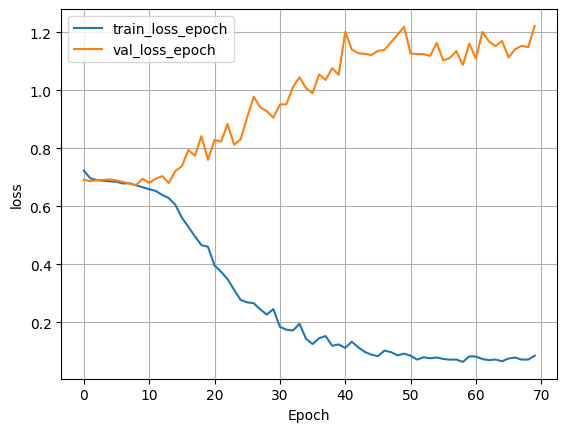

In [59]:
for i in range(1):
    train_dataset.set_active_fold(i)
    test_dataset.set_active_fold(i)
    # max_token_count = max(train_dataset.max_token_count, test_dataset.max_token_count)
    train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
    test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
    # for j in range(3):
    model_manager = train_model(70, 0.2, 0.000012, 0.0032)
    time.sleep(60)
    torch.cuda.empty_cache()
    import gc
    gc.collect()
    time.sleep(60)

In [ ]:
for i in range(1):
    train_dataset.set_active_fold(i)
    test_dataset.set_active_fold(i)
    # max_token_count = max(train_dataset.max_token_count, test_dataset.max_token_count)
    train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
    test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
    for j in range(3):
        model_manager = train_model(30, 0.2, 0.000012, 0.0032)
        time.sleep(60)
        torch.cuda.empty_cache()
        import gc
        gc.collect()
        time.sleep(60)

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00, 11.02it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9412    0.4800    0.6358       100
           1     0.6510    0.9700    0.7791       100

    accuracy                         0.7250       200
   macro avg     0.7961    0.7250    0.7074       200
weighted avg     0.7961    0.7250    0.7074       200

confusion matrix:
 tensor([[48, 52],
        [ 3, 97]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9298    0.5300    0.6752       100
           1     0.6713    0.9600    0.7901       100

    accuracy                         0.7450       200
   macro avg     0.8006    0.7450    0.7326       200
weighted avg     0.8006    0.7450    0.7326       200

confusion matrix:
 tensor([[53, 47],
        [ 4, 96]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_for_Text       | 409 K  | train
1 | loss_func | BCEWithLogitsLoss  | 0      | train
2 | train_acc | MulticlassAcc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 4/4 [00:00<00:00,  9.94it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9459    0.3500    0.5109       100
           1     0.6012    0.9800    0.7452       100

    accuracy                         0.6650       200
   macro avg     0.7736    0.6650    0.6281       200
weighted avg     0.7736    0.6650    0.6281       200

confusion matrix:
 tensor([[35, 65],
        [ 2, 98]])


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


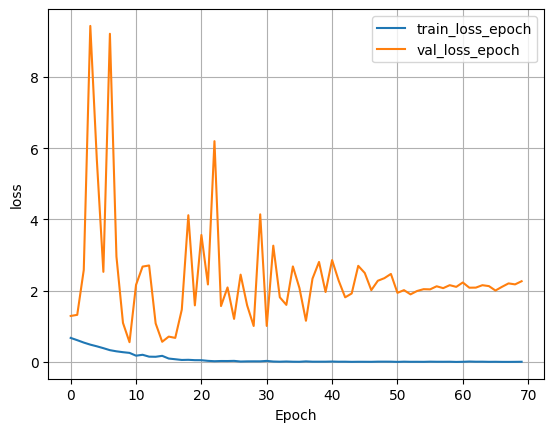

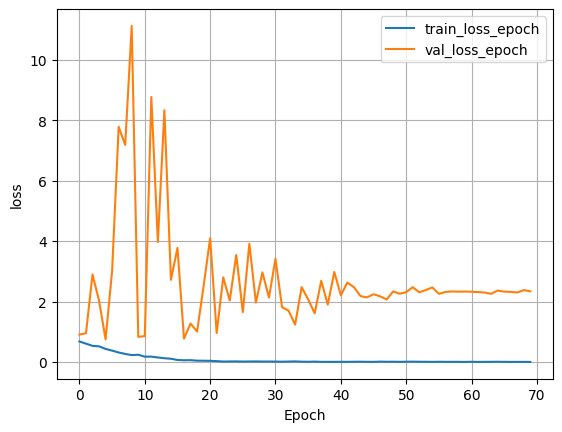

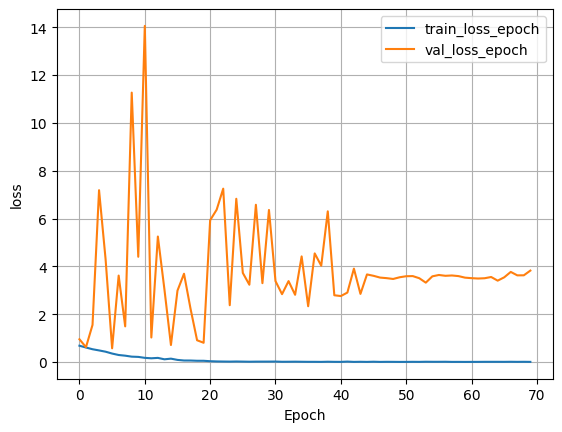

In [ ]:
for i in range(1):
    train_dataset.set_active_fold(i)
    test_dataset.set_active_fold(i)
    # max_token_count = max(train_dataset.max_token_count, test_dataset.max_token_count)
    train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
    test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
    for j in range(3):
        model_manager = train_model(30, 0.2, 0.000012, 0.0032)
        time.sleep(60)
        torch.cuda.empty_cache()
        import gc
        gc.collect()
        time.sleep(60)